# Task 3: Customer Segmentation / Clustering

## Importing required libraries

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

## Loading the datasets

In [2]:
customers_df = pd.read_csv("Customers.csv")
products_df = pd.read_csv("Products.csv")
transactions_df = pd.read_csv("Transactions.csv")

## Feature Engineering and Data Preparation: Using customer profile and transaction data for clustering

In [3]:
# Merge transactions with products to include product details
transactions_products_df = pd.merge(transactions_df, products_df, on="ProductID")

# Aggregate transaction data by CustomerID
customer_behavior_df = transactions_products_df.groupby("CustomerID").agg({
    "TotalValue": "sum",
    "Quantity": "sum",
    "Category": lambda x: x.mode()[0]  # Most frequently purchased category
}).reset_index()

# Encode categories as numeric values
customer_behavior_df["Category_Encoded"] = customer_behavior_df["Category"].astype('category').cat.codes

# Merge with customer profiles
customer_profile_df = pd.merge(customers_df, customer_behavior_df, on="CustomerID")

# Prepare features for clustering
features = customer_profile_df[["TotalValue", "Quantity", "Category_Encoded"]].values

# Normalize features for clustering
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

## Clustering: Using K-Means clustering to segment customers

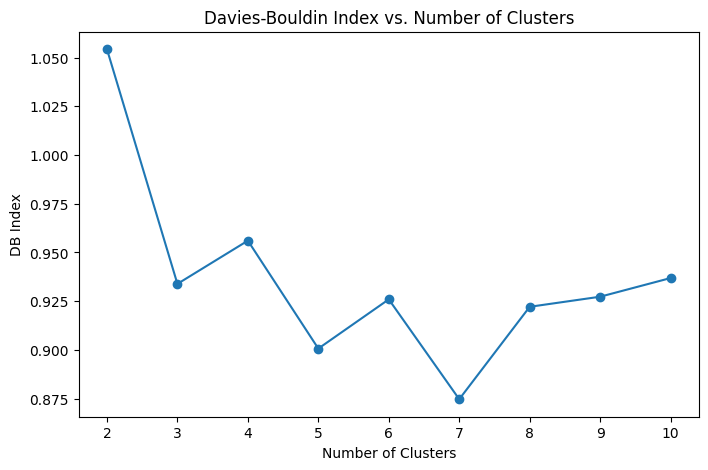

In [4]:
# Determine the optimal number of clusters using DB Index
db_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_features)
    labels = kmeans.labels_
    db_score = davies_bouldin_score(normalized_features, labels)
    db_scores.append(db_score)

# Plot DB Index vs. Number of Clusters
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), db_scores, marker="o")
plt.title("Davies-Bouldin Index vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("DB Index")
plt.show()

# Choose the optimal number of clusters and perform clustering
optimal_k = db_scores.index(min(db_scores)) + 2  # Adding 2 because range starts from 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(normalized_features)
customer_profile_df["Cluster"] = kmeans.labels_

## Visualization: Visualizing clusters using a scatter plot

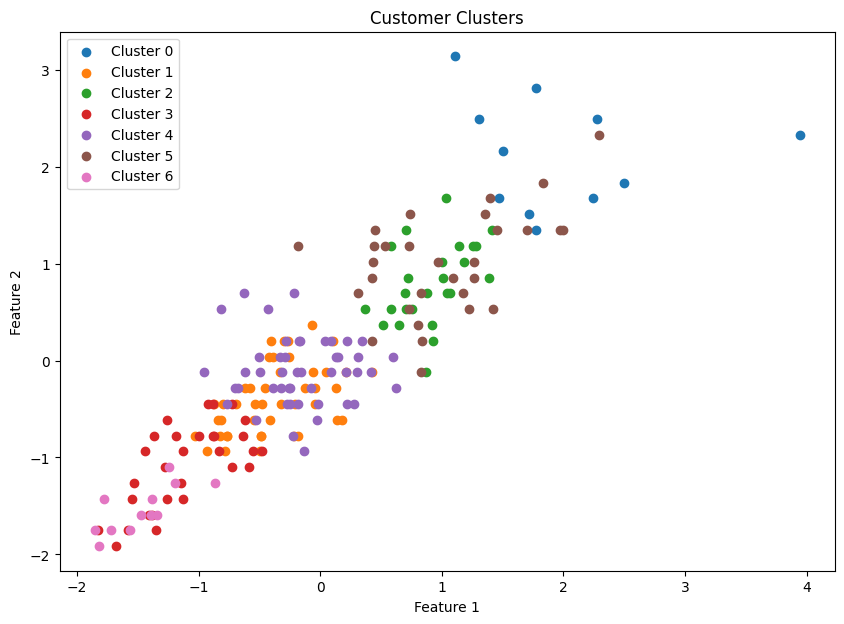

In [5]:
plt.figure(figsize=(10, 7))
for cluster in range(optimal_k):
    cluster_data = normalized_features[customer_profile_df["Cluster"] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f"Cluster {cluster}")

plt.title("Customer Clusters")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()